# FLI with compositional score matching


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import median_abs_deviation as mad

from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, euler_maruyama_sampling, train_score_model
from diffusion_model.helper_networks import ShallowSet
from diffusion_model.time_series_summary_nets import TimeSeriesNetwork
from problems.fli import FLIProblem, FLI_Prior, generate_synthetic_data
from problems import plot_shrinkage, visualize_simulation_output

In [ ]:
torch_device = torch.device("mps")

In [ ]:
prior = FLI_Prior()
batch_size = 64
number_of_obs = 1#[4]
max_number_of_obs = number_of_obs if isinstance(number_of_obs, int) else max(number_of_obs)

current_sde = SDE(
    kernel_type='variance_preserving',
    noise_schedule='cosine'
)

dataset = FLIProblem(
    n_data=30000,
    prior=prior,
    sde=current_sde,
    online_learning=True,
    number_of_obs=number_of_obs,
)

dataset_valid = FLIProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
    number_of_obs=number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

for test in dataloader:
    print(test[0].shape)
    print(test[2].shape)
    print(test[4].shape)
    break

In [ ]:
# Define diffusion model
n_blocks = [5,6][0]
hidden_dim = [256, 512][0]
hidden_dim_summary = [10, 14, 18, 22, 32][0]
split_summary_vector = [True, False][0]
#n_blocks, hidden_dim, hidden_dim_summary, split_summary_vector = list(itertools.product(n_blocks, hidden_dim, hidden_dim_summary, split_summary_vector))[0]

summary_net = TimeSeriesNetwork(input_dim=1, recurrent_dim=256, summary_dim=hidden_dim_summary)

global_summary_dim = hidden_dim_summary
global_summary_net = ShallowSet(dim_input=hidden_dim_summary, dim_output=global_summary_dim, dim_hidden=128)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x_global=global_summary_dim,
    input_dim_x_local=hidden_dim_summary,
    summary_net=summary_net,
    global_summary_net=global_summary_net if isinstance(number_of_obs, list) else None,
    hidden_dim=hidden_dim,
    n_blocks=n_blocks,
    max_number_of_obs=max_number_of_obs,
    prediction_type='v',
    sde=current_sde,
    weighting_type='likelihood_weighting',
    prior=prior,
    dropout_rate=0.1,
    name_prefix=f'FLI_{max_number_of_obs}_{hidden_dim_summary}_{hidden_dim}_{n_blocks}{"_split" if split_summary_vector else ""}_{summary_net.name}_',
    split_summary_vector=split_summary_vector
)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

In [ ]:
if not os.path.exists(f"models/{score_model.name}.pt"):
    # train model
    loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid, hierarchical=True,
                                                  epochs=3000, device=torch_device)
    score_model.eval()
    torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

    # plot loss history
    plt.figure(figsize=(16, 4), tight_layout=True)
    plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
    plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
    plt.grid(alpha=0.5)
    plt.xlabel('Training epoch #')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(f'plots/{score_model.name}/loss_training.png')
else:
    score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", map_location=torch_device, weights_only=True))
    score_model.eval()

# Validation

In [ ]:
n_local_samples = 32**2
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior=prior, n_data=100,
                                                                            n_local_samples=n_local_samples,
                                                                            random_seed=0)
n_post_samples = 100
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_local_samples)
#score_model.current_number_of_obs = 4  # we can choose here, how many observations are passed together through the score
score_model.current_number_of_obs = max_number_of_obs
print(valid_data.shape, score_model.current_number_of_obs)

In [ ]:
t1_value = 0.001
t0_value = 0.4
sampling_arg = {
    'size': 2,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * t),
    #'damping_factor': lambda t: (1-torch.ones_like(t)) * 1/(n_local_samples-500) + 0.01,
    #'damping_factor': lambda t: (1-torch.ones_like(t)) * 1/(n_local_samples-900) + 0.01,
    #'damping_factor': lambda t: torch.ones_like(t) * 1e-10 + 0.0001,
    #'sampling_chunk_size': 512,
}
score_model.sde.s_shift_cosine = 1

In [ ]:
#score_model.sde.s_shift_cosine = 4
# posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
#                                                    n_post_samples=n_post_samples,
#                                                    #sampling_arg=sampling_arg,
#                                                    run_sampling_in_parallel=False,
#                                                    device=torch_device, verbose=True)

posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                         n_post_samples=n_post_samples,
                                                         sampling_arg=sampling_arg,
                                                         diffusion_steps=500, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
#fig.savefig(f'plots/{score_model.name}/recovery_global.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
#fig.savefig(f'plots/{score_model.name}/ecdf_global.png')

In [ ]:
score_model.sde.s_shift_cosine = 0
score_model.current_number_of_obs = 1
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                        n_post_samples=n_post_samples, conditions=posterior_global_samples_valid,
                                                        diffusion_steps=100, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1)[:, :, :12],
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1)[:, :12],
                          variable_names=local_param_names[:12])
#fig.savefig(f'plots/{score_model.name}/recovery_local.png')

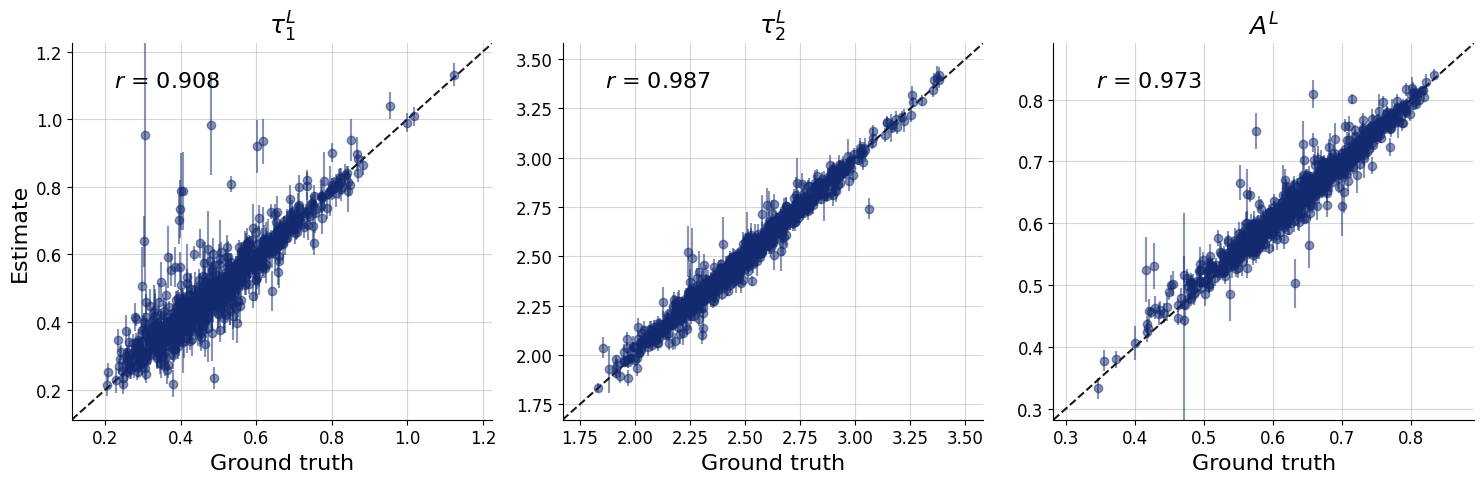

In [127]:
# plot locals for a single grid
for i in range(14, 15):
    tau, tau_2, A = prior.transform_raw_params(
        log_tau=posterior_local_samples_valid[i:i+1, :, :, 0],
        log_delta_tau=posterior_local_samples_valid[i:i+1, :, :, 1],
        a=posterior_local_samples_valid[i:i+1, :, :, 2],
    )
    tau_mean = A * tau + (1-A) * tau_2
    posterior_local_samples_valid_transf = np.concatenate([tau[:, :, :, np.newaxis], tau_2[:, :, :, np.newaxis], A[:, :, :, np.newaxis], tau_mean[:, :, :, np.newaxis]], axis=-1)

    tau, tau_2, A = prior.transform_raw_params(
        log_tau=valid_prior_local[i:i+1, :, 0],
        log_delta_tau=valid_prior_local[i:i+1, :, 1],
        a=valid_prior_local[i:i+1, :, 2],
    )
    tau_mean = A * tau + (1-A) * tau_2
    valid_prior_local_transf = np.concatenate([tau[:, :, np.newaxis], tau_2[:,  :, np.newaxis], A[:, :, np.newaxis], tau_mean[:, :, np.newaxis]], axis=-1)


    fig = diagnostics.recovery(np.transpose(posterior_local_samples_valid_transf, (0,2,1,3)).reshape(-1, n_post_samples, 4)[:, :, :3],
                         valid_prior_local_transf.reshape(-1, 4)[:, :3],
                         variable_names=[r'$\tau_1^L$', r'$\tau_2^L$', r'$A^L$']) #, r'$\tau_\text{mean}^L$'])
    #fig.savefig("plots/hierarchical_simulated_recovery.pdf")
    plt.show()

In [ ]:
plot_shrinkage(posterior_global_samples_valid[:12], posterior_local_samples_valid[:12], min_max=(-10, 10))

 # Apply the Model to Real Data

In [93]:
global_param_names = prior.global_param_names

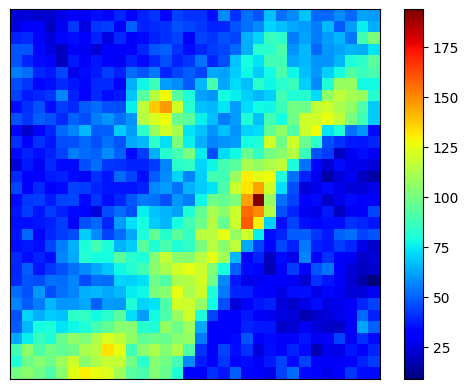

In [115]:
grid_data = 32
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(grid_data * grid_data)

x_offset = 225
y_offset = 245
binned_data = np.load('problems/FLI/exp_binned_data.npy')[x_offset:x_offset+grid_data, y_offset:y_offset+grid_data]
binned_data = binned_data.reshape(1, grid_data * grid_data, 256, 1)

data = np.load('problems/FLI/final_Data.npy')[:, x_offset:x_offset+grid_data, y_offset:y_offset+grid_data]
data = data.reshape(1, grid_data * grid_data, 256, 1)
cut_off = 17
binary_mask = (np.sum(data, axis=2, keepdims=True) > cut_off)
norm = np.max(data, axis=2, keepdims=True)
norm[~binary_mask] = 1
real_data = data / norm

plt.imshow(np.sum(data[0], axis=(1,2)).reshape(grid_data, grid_data), cmap='jet')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [95]:
t1_value = 0.0009
t0_value = 1
n_post_samples = 100
sampling_arg = {
    'size': 2,
    #'damping_factor': lambda t: (torch.ones_like(t) / real_data.shape[1] * 100) * (t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t)),
    #'damping_factor': lambda t: (1-torch.ones_like(t)) / real_data.shape[1] + 0.1,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': lambda t: (1-torch.ones_like(t)) * 1/(grid_data**2) * 0.0001 + 0.001,
    #'damping_factor': lambda t: torch.ones_like(t) * 1/(grid_data**2) + 0.1,
    'damping_factor': lambda t: torch.ones_like(t) * 1e-10 + 0.0001,
    #'damping_factor': lambda t: (1-torch.ones_like(t)) * 1e-7 + 2e-4,
    #'sampling_chunk_size': 512,
    "sampling_weights": binary_mask.flatten() * 1,
}
score_model.sde.s_shift_cosine = 0

In [96]:
posterior_global_samples_real = euler_maruyama_sampling(score_model, real_data,
                                                         n_post_samples=n_post_samples,
                                                         sampling_arg=sampling_arg,
                                                         diffusion_steps=300, device=torch_device, verbose=True)

100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


In [97]:
prior_dict = {}
posterior_dict = {}
prior_tranf_dict = {}
posterior_tranf_dict = {}
for i in range(len(global_param_names)):
    prior_dict[global_param_names[i]] = valid_prior_global[:, i]
    posterior_dict[global_param_names[i]] = posterior_global_samples_real[0, :, i]

tau, tau_2, A = prior.transform_raw_params(
        log_tau=prior_dict[global_param_names[0]],
        log_delta_tau=prior_dict[global_param_names[2]],
        a=prior_dict[global_param_names[4]]
    )
prior_tranf_dict = {
    r'$\tau$': tau,
    r'$\tau_2$': tau_2,
    r'$A$': A
}

tau, tau_2, A = prior.transform_raw_params(
        log_tau=posterior_dict[global_param_names[0]],
        log_delta_tau=posterior_dict[global_param_names[2]],
        a=posterior_dict[global_param_names[4]]
    )
posterior_tranf_dict = {
    r'$\tau$': tau,
    r'$\tau_2$': tau_2,
    r'$A$': A
}
print(r'$\tau$', np.median(tau))
print(r'$\tau_2$', np.median(tau_2))
print(r'$A$', np.median(A))

$\tau$ 0.7087631
$\tau_2$ 1.3515089
$A$ 0.69279695


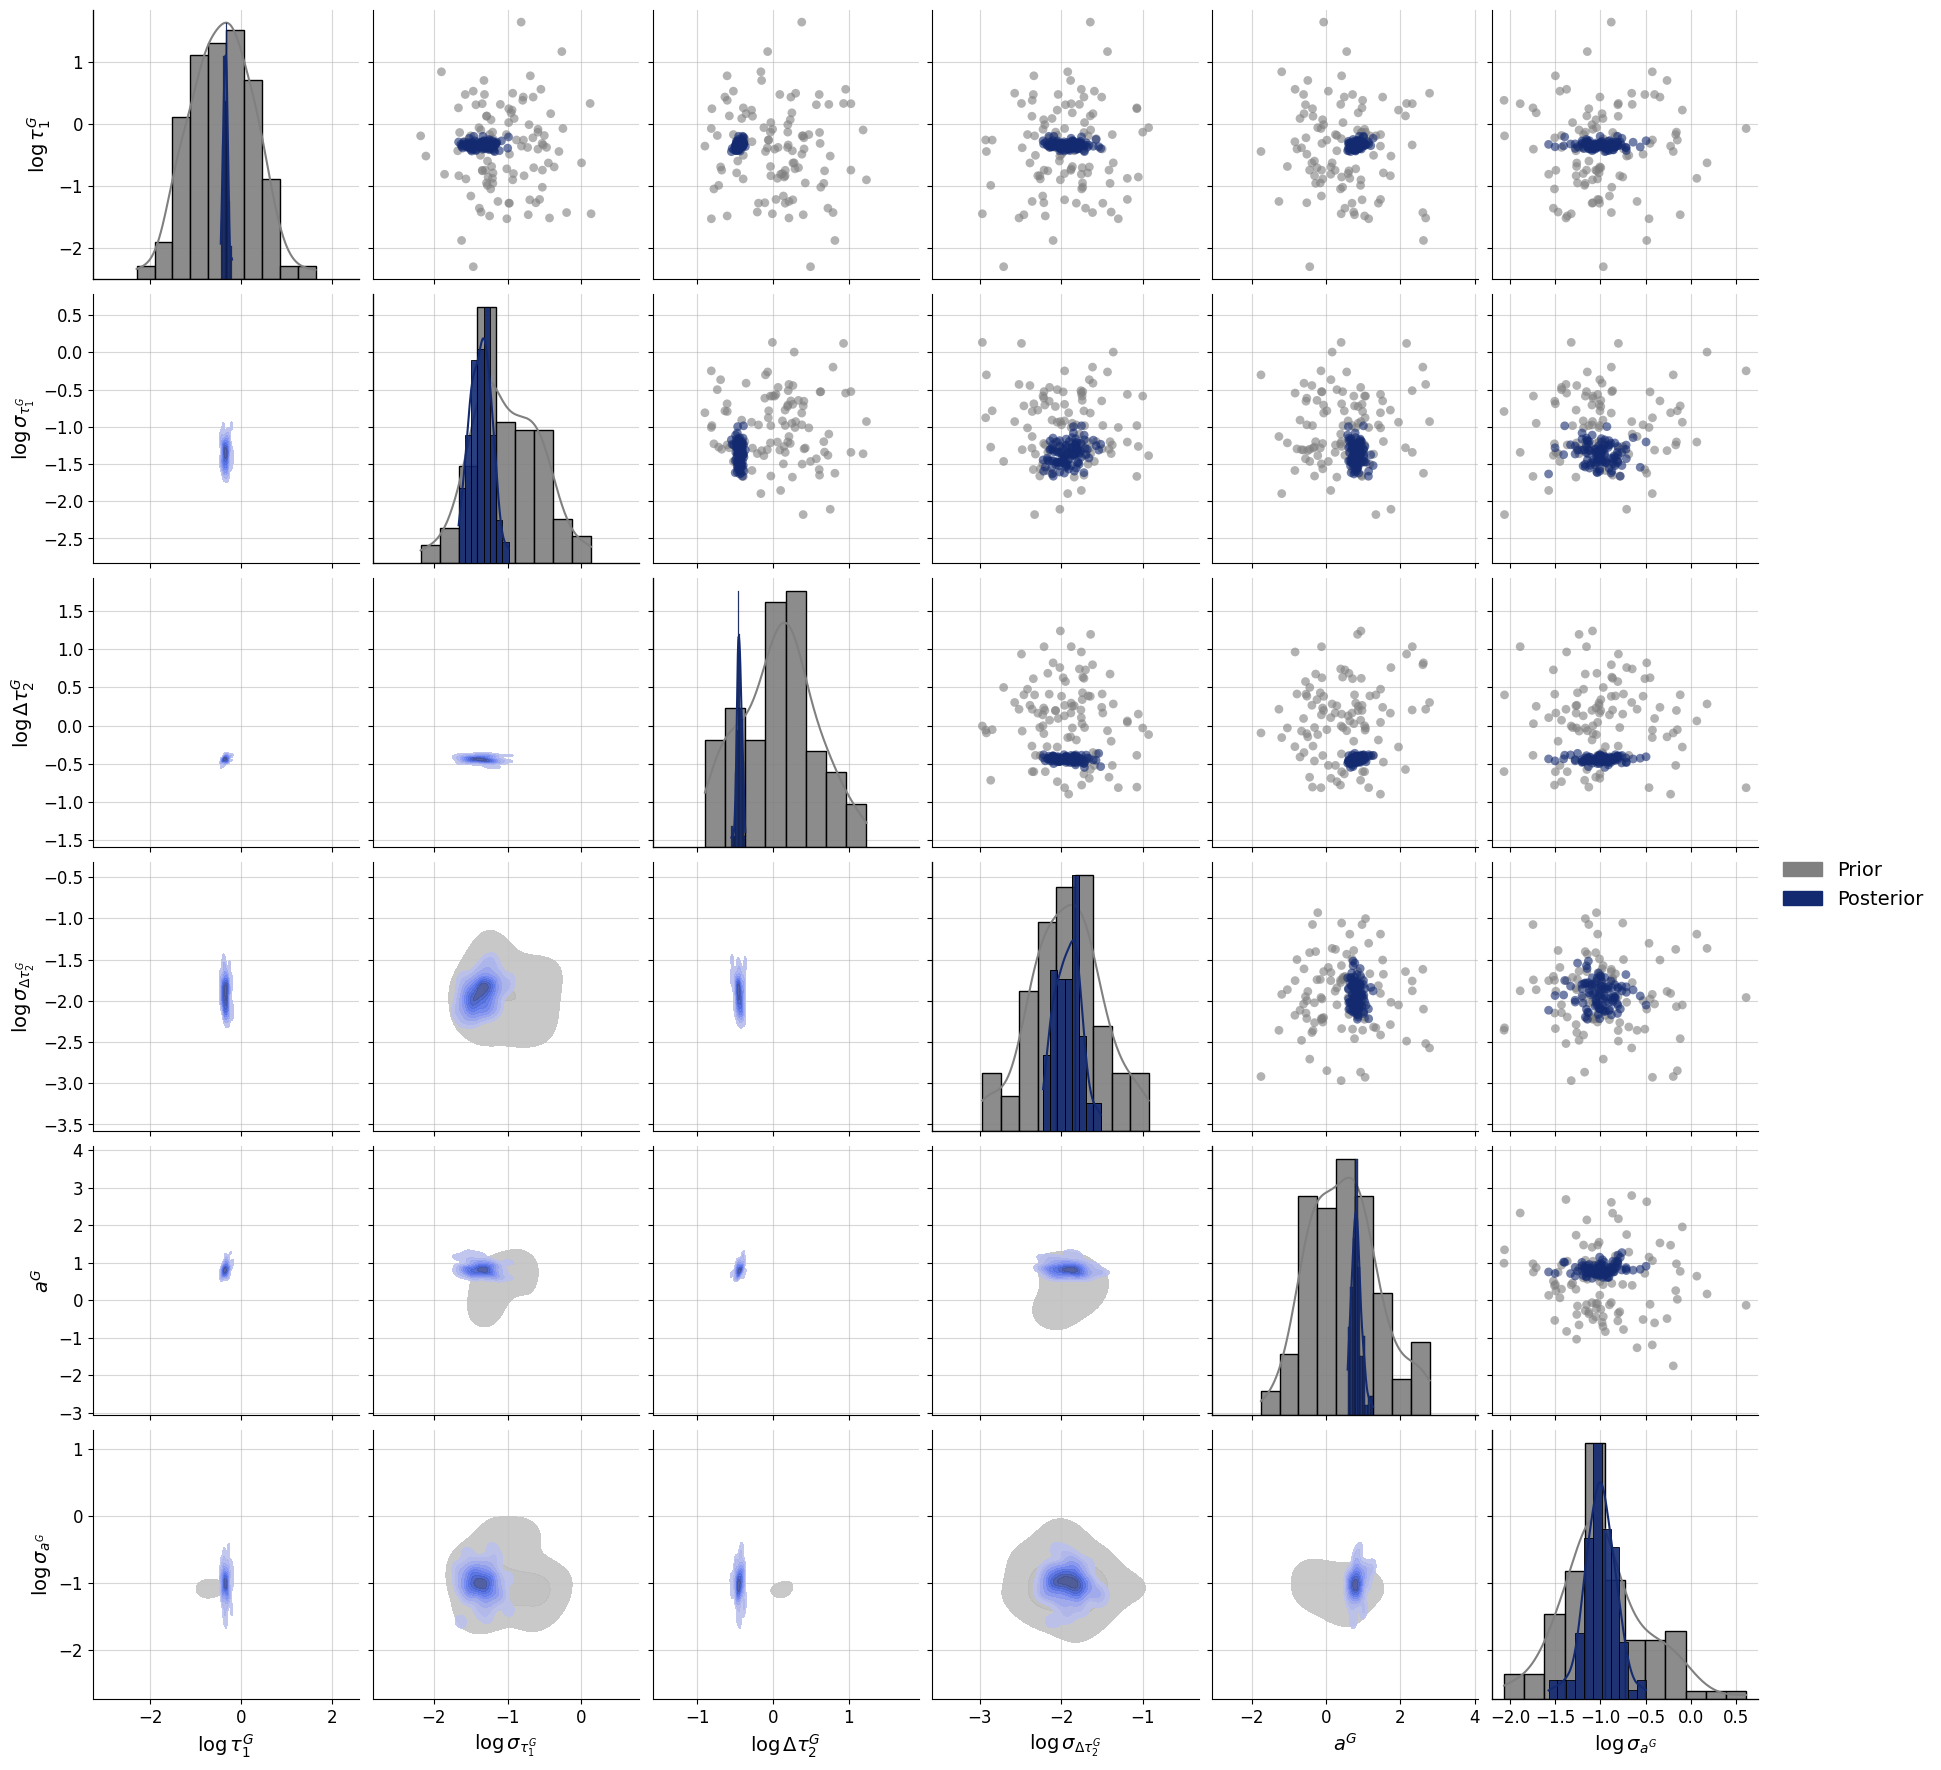

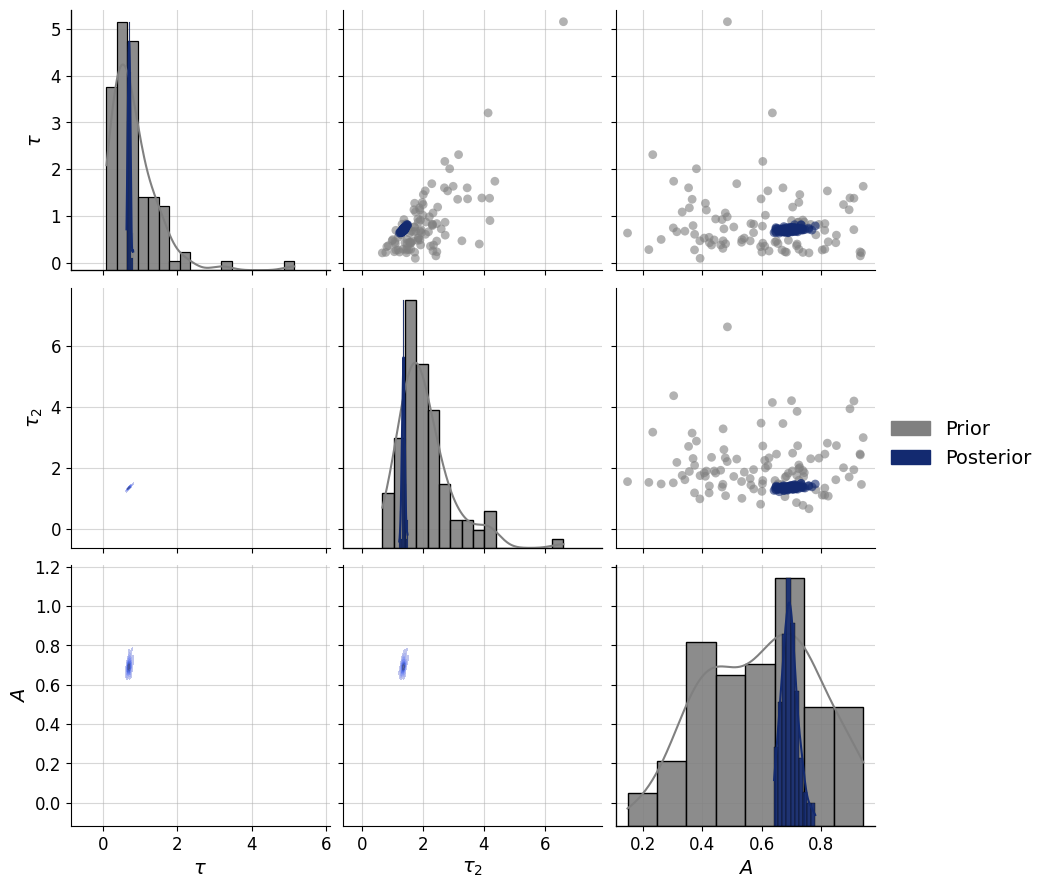

In [98]:
fig = diagnostics.pairs_posterior(
    posterior_dict,
    priors=prior_dict,
)
#fig.savefig(f'plots/real_data_global_posterior.pdf')

fig = diagnostics.pairs_posterior(
    posterior_tranf_dict,
    priors=prior_tranf_dict,
)
#fig.savefig(f'plots/real_data_global_posterior_transf.pdf')

In [99]:
np.median(posterior_global_samples_real[0], axis=0)

array([-0.3442352, -1.3561902, -0.4419448, -1.9264326,  0.8132312,
       -1.0045737], dtype=float32)

In [116]:
score_model.sde.s_shift_cosine = 0
posterior_local_samples_real = euler_maruyama_sampling(score_model, real_data,
                                                        conditions=posterior_global_samples_real,
                                                        n_post_samples=n_post_samples,
                                                        diffusion_steps=100, device=torch_device, verbose=True)

applying summary network to observations before sampling, might take a while...


100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


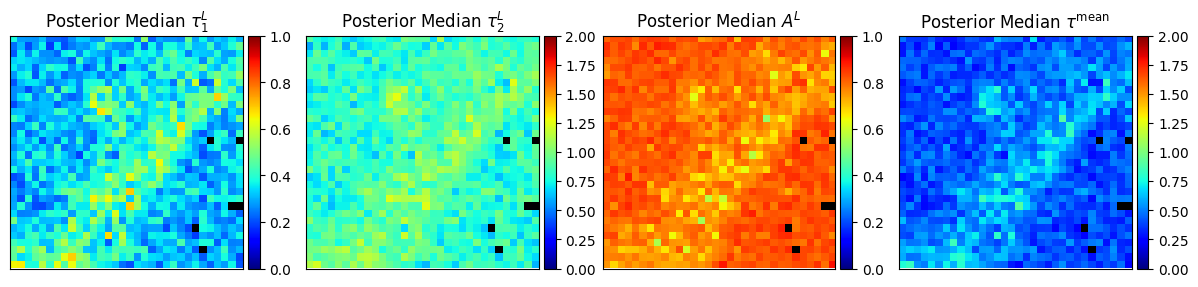

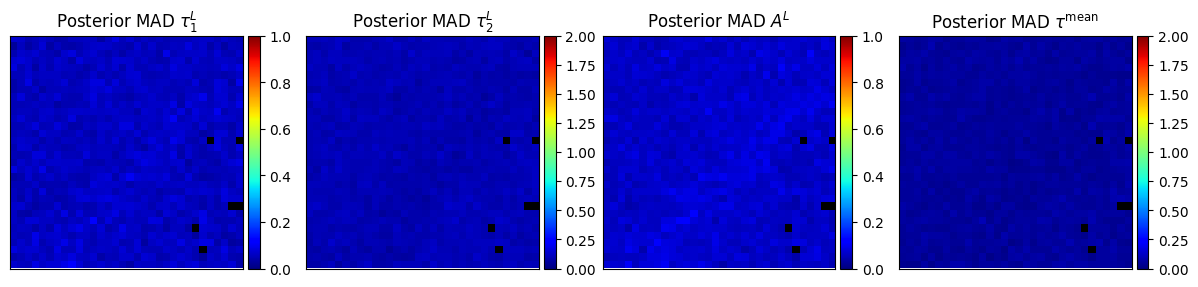

In [117]:
tau, tau_2, A = prior.transform_raw_params(
    log_tau=posterior_local_samples_real[0, :, :, 0].reshape(n_post_samples, grid_data, grid_data),
    log_delta_tau=posterior_local_samples_real[0, :, :, 1].reshape(n_post_samples, grid_data, grid_data),
    a=posterior_local_samples_real[0, :, :, 2].reshape(n_post_samples, grid_data, grid_data),
)
tau_mean = A * tau + (1-A) * tau_2
ps = np.concatenate([tau[:, :, :, np.newaxis], tau_2[:, :, :, np.newaxis], A[:, :, :, np.newaxis], tau_mean[:, :, :, np.newaxis]], axis=-1)
transf_local_param_names = [r'$\tau_1^L$', r'$\tau_2^L$', r'$A^L$', r'$\tau^\text{mean}$']

med = np.median(ps, axis=0)
posterior_mad = mad(ps, axis=0)
visualize_simulation_output(med,
                            mask=binary_mask.reshape(grid_data, grid_data),
                            title_prefix=['Posterior Median ' + p for p in transf_local_param_names],
                            cmap='jet', scales=[(0,1), (0, 2), (0,1), (0, 2)], add_scale_bar=False)#, save_path=f"plots/real_data_median.pdf")
visualize_simulation_output(posterior_mad,
                            mask=binary_mask.reshape(grid_data, grid_data),
                            title_prefix=['Posterior MAD ' + p for p in transf_local_param_names],
                            cmap='jet', scales=[(0,1), (0, 2), (0,1), (0, 2)], add_scale_bar=False)#, save_path=f"plots/real_data_mad.pdf")

#np.save('fli_local_median', med)
#np.save('fli_local_mad', posterior_mad)

[16, 15]
[21, 15]


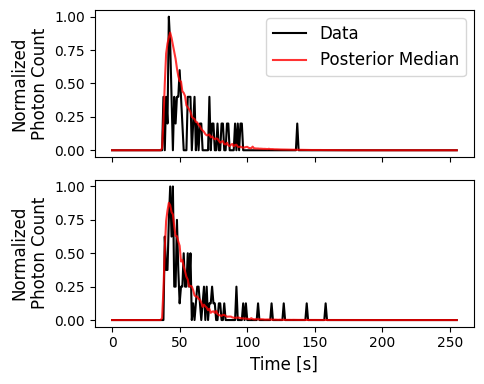

In [124]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.size": 12,            # Base font size
    "axes.titlesize": 12,       # Axes title
    "axes.labelsize": 12,       # Axes labels
    "xtick.labelsize": 10,      # Tick labels
    "ytick.labelsize": 10,
})

fig, axis = plt.subplots(2, 1, figsize=(5, 4), tight_layout=True, sharex=True, sharey=True)
axis = axis.flatten()
for i, ax in enumerate(axis):
    while True:
        pixel_ids = [np.random.randint(0, grid_data), np.random.randint(0, grid_data)]
        pixel_ids = [[16, 15], [21, 15]][i]
        if binary_mask.reshape(grid_data, grid_data)[pixel_ids[0], pixel_ids[1]]:
            break  # only plot meaningful data
    print(pixel_ids)
    simulations = np.array([
        prior.simulator.decay_gen_single(
            tau_L=tau[post_index, pixel_ids[0], pixel_ids[1]],
            tau_L_2=tau_2[post_index, pixel_ids[0], pixel_ids[1]],
            A_L=A[post_index, pixel_ids[0], pixel_ids[1]]
        ) for post_index in range(tau.shape[0])
    ])

    ax.plot(real_data.reshape(grid_data, grid_data, 256)[pixel_ids[0], pixel_ids[1]], label='data', color='black')
    ax.plot(np.median(simulations, axis=0), label='posterior median', alpha=0.8, color='red')
    # ax.fill_between(
    #     np.arange(simulations.shape[1]),
    #     np.quantile(simulations, 0.025, axis=0),
    #     np.quantile(simulations, 0.975, axis=0),
    #     alpha=0.4,
    #     color='orange',
    #     label='posterior 95% CI'
    # )
    if i == 0:
        ax.legend(labels=[r'Data', r'Posterior Median', r'Posterior 95% CI'][:2], #bbox_to_anchor=(0.5, -0.07),
                  ncol=1, loc='upper right')
    if i == len(axis) - 1:
        ax.set_xlabel(r'Time [s]')
    ax.set_ylabel('Normalized\nPhoton Count')

plt.savefig(f'plots/real_data_fit.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
np.max(real_data)